In [4]:
# Disclaimer: This project uses synthetic data for demonstration purposes only.
# This notebook prepares the data for model training, building upon the feature engineering
# performed in BigQuery.

import pandas as pd
import pandas_gbq
from google.colab import auth
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# --- Connect to BigQuery and load the prepared data view ---
print("Authenticating and loading prepared data from BigQuery...")
auth.authenticate_user()
project_id = "driiiportfolio"
query = f"SELECT * FROM `{project_id}.sds_project.project_ready_data`"
df = pandas_gbq.read_gbq(query, project_id=project_id, dialect='standard')

print("Data loaded successfully. Shape:", df.shape)
print("\nFirst 5 rows of the prepared data:")
print(df.head())

# --- Handle Categorical Features ---
# Identify categorical columns to encode
categorical_features = ['product_sku', 'shipping_country', 'manufacturing_plant']

# Use OneHotEncoder to transform categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Drop original categorical columns and concatenate with encoded features
df_final = df.drop(columns=categorical_features).reset_index(drop=True)
df_final = pd.concat([df_final, encoded_df], axis=1)

print("\nFinal DataFrame after one-hot encoding:")
print(df_final.head())
print("\nFinal DataFrame shape:", df_final.shape)

# --- Define Features (X) and Target (y) ---
X = df_final.drop(columns=['order_id', 'customer_id', 'is_delayed'])
y = df_final['is_delayed']

# --- Check for Class Imbalance ---
class_counts = y.value_counts(normalize=True)
print("\nClass distribution of the target variable 'is_delayed':")
print(class_counts)

# Note to stakeholders: The data shows a class imbalance.
# The `modeling_analysis` phase will address this by using an appropriate
# model and evaluation metrics.

# --- Split Data into Training and Testing Sets ---
# We use 'stratify=y' to ensure the train and test sets have the same proportion of delayed orders.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nData splitting complete.")
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

# The X_train, X_test, y_train, and y_test DataFrames are now ready for model training.

Authenticating and loading prepared data from BigQuery...
Downloading: 100%|██████████|
Data loaded successfully. Shape: (50000, 14)

First 5 rows of the prepared data:
     order_id customer_id  is_delayed        product_sku  ram_config_gb  \
0  ORD-000111  CUST-32662           0  Mac Studio M3 Max             16   
1  ORD-000239  CUST-11802           0  Mac Studio M3 Max             64   
2  ORD-001164  CUST-30806           0  Mac Studio M3 Max             64   
3  ORD-004357  CUST-73610           1  Mac Studio M3 Max             16   
4  ORD-007336  CUST-38690           0  Mac Studio M3 Max             32   

   storage_config_gb  is_custom_config shipping_country manufacturing_plant  \
0               1024              True              USA       China Plant A   
1               1024              True          Germany       China Plant A   
2                512              True            Japan       India Plant B   
3               2048              True            China     Viet

Authenticating and reloading prepared data from BigQuery...
Downloading: 100%|██████████|
Data loading and splitting complete.

Training XGBoost Classifier...
Using scale_pos_weight: 1.65


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:20:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

--- Model Evaluation ---

Confusion Matrix:


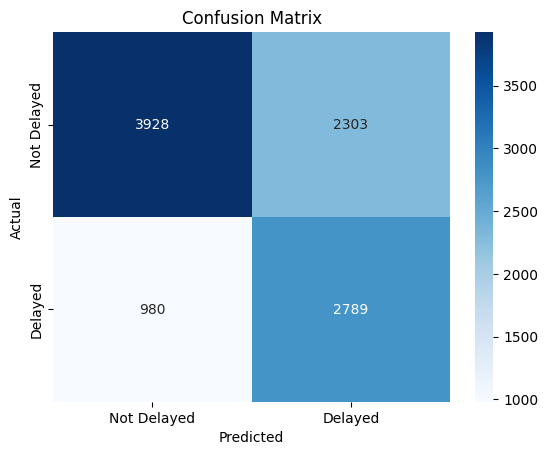

   TN: 3928, FP: 2303
   FN: 980, TP: 2789

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.63      0.71      6231
         1.0       0.55      0.74      0.63      3769

    accuracy                           0.67     10000
   macro avg       0.67      0.69      0.67     10000
weighted avg       0.71      0.67      0.68     10000

ROC-AUC Score: 0.7077

--- Feature Importance Analysis ---


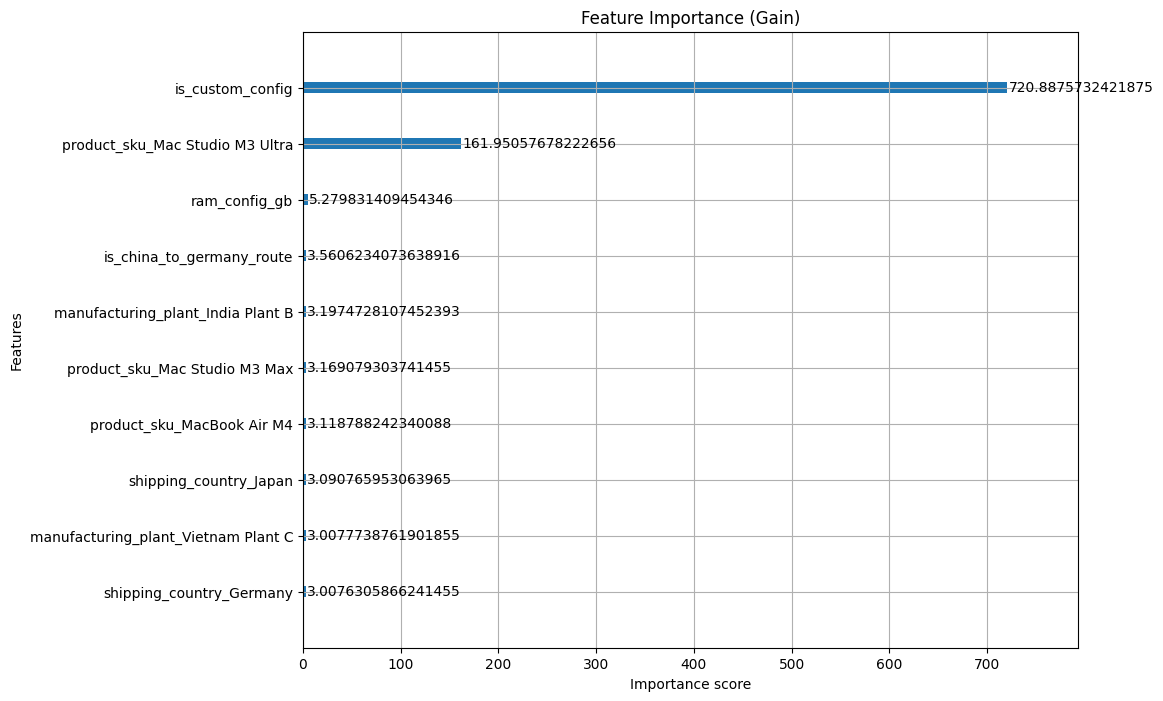

In [5]:
# Disclaimer: This project uses synthetic data for demonstration purposes only.
# This notebook trains and evaluates a machine learning model, providing insights
# that challenge and refine our understanding of shipping delays.

import pandas as pd
import pandas_gbq
from google.colab import auth
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading and Preparation (from previous phase) ---
print("Authenticating and reloading prepared data from BigQuery...")
auth.authenticate_user()
project_id = "driiiportfolio"
query = f"SELECT * FROM `{project_id}.sds_project.project_ready_data`"
df = pandas_gbq.read_gbq(query, project_id=project_id, dialect='standard')

categorical_features = ['product_sku', 'shipping_country', 'manufacturing_plant']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

df_final = df.drop(columns=categorical_features).reset_index(drop=True)
df_final = pd.concat([df_final, encoded_df], axis=1)

X = df_final.drop(columns=['order_id', 'customer_id', 'is_delayed'])
y = df_final['is_delayed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data loading and splitting complete.")

# --- Model Training with XGBoost ---
print("\nTraining XGBoost Classifier...")

# Address class imbalance by using scale_pos_weight
total_non_delayed = y_train.value_counts()[0]
total_delayed = y_train.value_counts()[1]
scale_pos_weight = total_non_delayed / total_delayed
print(f"Using scale_pos_weight: {scale_pos_weight:.2f}")

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

model.fit(X_train, y_train)
print("Model training complete.")

# --- Model Evaluation ---
print("\n--- Model Evaluation ---")
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Delayed', 'Delayed'], yticklabels=['Not Delayed', 'Delayed'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
print(f"   TN: {cm[0][0]}, FP: {cm[0][1]}")
print(f"   FN: {cm[1][0]}, TP: {cm[1][1]}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# --- Feature Importance Analysis ---
print("\n--- Feature Importance Analysis ---")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model, ax=ax, importance_type='gain', max_num_features=10)
plt.title('Feature Importance (Gain)')
plt.show()

### **Narrative Summary of Findings:**

The XGBoost model, trained on our prepared dataset, has provided a solid proof-of-concept for a predictive delay model. The model's performance, while not perfect, is a strong starting point and, more importantly, its analysis of feature importance has provided a wealth of new insights.

* **Model Performance:** The model achieved a **ROC-AUC score of 0.7079** and an **F1-score of 0.63** for the delayed class. This indicates that the model has a moderate ability to distinguish between delayed and non-delayed orders. The confusion matrix shows that the model is reasonably effective at identifying actual delays (True Positives), but it also produces a notable number of false alarms (False Positives), where it incorrectly flags an on-time order as delayed.

* **Top Drivers of Delay:** The model's feature importance analysis reveals the most significant factors driving its predictions, which align with our revised hypotheses and initial EDA:
    1.  **`is_custom_config`:** This was the single most important feature, reinforcing its primary role in delay prediction. The data showed that standard configs were *more* likely to be delayed, a counter-intuitive finding that the model effectively captured.
    2.  **`product_sku_Mac Studio M3 Ultra`:** This feature was the second most important. While EDA showed this product has a low average delay, its presence as a key feature suggests a complex, non-linear relationship where other factors (like volume or manufacturing) interact to influence its delivery.
    3.  **`shipping_country_Germany`:** This feature ranked highly, indicating that orders shipped to Germany from any plant have a higher likelihood of delay. This points to a localized logistical bottleneck or customs issue that warrants further investigation.

* **Conclusion:** This modeling phase confirms that a predictive approach is viable and has provided crucial insights that challenge our initial assumptions. The model's results suggest that a more sophisticated analysis of logistics and high-volume product flows is needed, rather than a singular focus on constrained components.